In [ ]:
# OPTIONAL: If using google colab, install the neccesary packages
!pip install transformers[torch] datasets evaluate

In [3]:
# Load sequences and imports
import torch
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.utils import resample
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.stats import spearmanr
from sklearn.metrics import ndcg_score
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, normalize
from sklearn.model_selection import KFold
from sklearn.utils import resample
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.ticker as ticker
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn.metrics import ndcg_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR, SVC
from sklearn.linear_model import Ridge
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer, AutoModelForMaskedLM, DataCollatorForLanguageModeling
from datasets import Dataset
from evaluate import load
from transformers import RobertaTokenizer, RobertaModel, RobertaConfig
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load sequences from csv
df = pd.read_csv('../Data/LazBF_sequences.csv')
LazBF_sequences = df['sequences'].tolist()
LazBF_labels = df['labels'].tolist()

df = pd.read_csv('../Data/LazBF_sample.csv')
LazBF_sample = df['sequences'].tolist()
LazBF_sample_labels = df['labels'].tolist()

df = pd.read_csv('../Data/LazDEF_sequences.csv')
LazDEF_sequences = df['sequences'].tolist()
LazDEF_labels = df['labels'].tolist()

df = pd.read_csv('../Data/LazDEF_sample.csv')
LazDEF_sample = df['sequences'].tolist()
LazDEF_sample_labels = df['labels'].tolist()

df = pd.read_csv('../Data/LazBCDEF_sequences.csv')
LazBCDEF_sequences = df['sequences'].tolist()
LazBCDEF_labels = df['labels'].tolist()

df = pd.read_csv('../Data/LazBCDEF_sample.csv')
LazBCDEF_sample = df['sequences'].tolist()
LazBCDEF_sample_labels = df['labels'].tolist()

In [4]:
# Load 650M-parameter fine-tuned models
LazBF_ft = AutoModelForSequenceClassification.from_pretrained('ShuklaGroupIllinois/LazBF_ESM2_ft').to(device)
LazDEF_ft = AutoModelForSequenceClassification.from_pretrained('ShuklaGroupIllinois/LazDEF_ESM2_ft').to(device)
LazBCDEF_ft = AutoModelForSequenceClassification.from_pretrained('ShuklaGroupIllinois/LazBCDEF_ESM_ft').to(device)
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
LazBF_ft.eval()
LazDEF_ft.eval()
LazBCDEF_ft.eval()

In [7]:
# Define trainers to evaluate the performance of each model on different data sets
training_args = TrainingArguments(
    output_dir="esm_finetuned",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    push_to_hub=False,
    fp16=True,
    load_best_model_at_end=True,
    gradient_accumulation_steps=2,
)

metric = load('accuracy')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

LazBF_trainer = Trainer(
    model=LazBF_ft,
    args=training_args,
    compute_metrics=compute_metrics
)

LazDEF_trainer = Trainer(
    model=LazDEF_ft,
    args=training_args,
    compute_metrics=compute_metrics
)

LazBCDEF_trainer = Trainer(
    model=LazBCDEF_ft,
    args=training_args,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [6]:
# Make data set objects out of the sequences
lbf = Dataset.from_dict(tokenizer(LazBF_sample))
lbf = lbf.add_column("labels", LazBF_sample_labels)

ldef = Dataset.from_dict(tokenizer(LazDEF_sample))
ldef = ldef.add_column("labels", LazDEF_sample_labels)

lbcdef = Dataset.from_dict(tokenizer(LazBCDEF_sample, padding='longest'))
lbcdef = lbcdef.add_column("labels", LazBCDEF_sample_labels)

In [ ]:
LazBF_trainer.evaluate(lbf)

{'eval_loss': 0.01695972867310047,
 'eval_accuracy': 0.99414,
 'eval_runtime': 87.4507,
 'eval_samples_per_second': 571.751,
 'eval_steps_per_second': 4.471}

In [ ]:
LazBF_trainer.evaluate(ldef)

{'eval_loss': 3.6631252765655518,
 'eval_accuracy': 0.50878,
 'eval_runtime': 95.6676,
 'eval_samples_per_second': 522.643,
 'eval_steps_per_second': 4.087}

In [ ]:
LazBF_trainer.evaluate(lbcdef)

{'eval_loss': 3.431755542755127,
 'eval_accuracy': 0.52228,
 'eval_runtime': 85.9272,
 'eval_samples_per_second': 581.888,
 'eval_steps_per_second': 4.55}

In [ ]:
LazDEF_trainer.evaluate(lbf)

{'eval_loss': 0.7584709525108337,
 'eval_accuracy': 0.74968,
 'eval_runtime': 86.6692,
 'eval_samples_per_second': 576.906,
 'eval_steps_per_second': 4.511}

In [ ]:
LazDEF_trainer.evaluate(ldef)

{'eval_loss': 0.02696620114147663,
 'eval_accuracy': 0.99196,
 'eval_runtime': 96.767,
 'eval_samples_per_second': 516.705,
 'eval_steps_per_second': 4.041}

In [ ]:
LazDEF_trainer.evaluate(lbcdef)

{'eval_loss': 1.4165822267532349,
 'eval_accuracy': 0.64324,
 'eval_runtime': 86.8597,
 'eval_samples_per_second': 575.641,
 'eval_steps_per_second': 4.502}

In [ ]:
LazBCDEF_trainer.evaluate(lbf)

{'eval_loss': 1.046639084815979,
 'eval_accuracy': 0.62616,
 'eval_runtime': 86.7373,
 'eval_samples_per_second': 576.453,
 'eval_steps_per_second': 4.508}

In [ ]:
LazBCDEF_trainer.evaluate(ldef)

{'eval_loss': 1.351431131362915,
 'eval_accuracy': 0.58872,
 'eval_runtime': 97.0778,
 'eval_samples_per_second': 515.051,
 'eval_steps_per_second': 4.028}

In [ ]:
LazBCDEF_trainer.evaluate(lbcdef)

{'eval_loss': 0.12052178382873535,
 'eval_accuracy': 0.95762,
 'eval_runtime': 86.6017,
 'eval_samples_per_second': 577.356,
 'eval_steps_per_second': 4.515}

---

In [11]:
#@title Scripts for interpretation
import torch
import numpy as np
from torch import tensor
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import LayerIntegratedGradients, TokenReferenceBase, IntegratedGradients

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
amino_acids = {'R': 0,'H': 1,'K': 2,'D': 3,'E': 4,'S': 5,'T': 6,'N': 7,'Q': 8,'C': 9,'G': 10,'P': 11,'A': 12,'V': 13,'I': 14,'L': 15,'M': 16,'F': 17,'Y': 18,'W': 19}
sm = torch.nn.Softmax(dim=1)

def forward_func(inputs: tensor, position = 0):
  pred = model.forward(inputs)
  return pred[position]

def explain(text: str, label):
  inputs = torch.tensor(tokenizer.encode(text, add_special_tokens=True), device=device).unsqueeze(0)
  prediction = model.forward(inputs)[0]
  baseline = torch.tensor([tokenizer.cls_token_id] + [tokenizer.pad_token_id] * (inputs.shape[1] - 2) + [tokenizer.eos_token_id], device = device).unsqueeze(0)
  lig = LayerIntegratedGradients(forward_func, model.esm.embeddings) # The layer which we want to get the IG's is the mebedding layer.
  attributes, delta = lig.attribute(inputs=inputs,
                            baselines=baseline,
                            target = label,
                            return_convergence_delta = True)
  attr_sum = attributes.sum(-1)
  return attr_sum.cpu().numpy()[0][1:-1]

# Saves all attention heads for each layer to image
def full_attention(model, sequence):
  input = tokenizer(sequence, return_tensors='pt').to(device)
  output = model.forward(input.input_ids, output_attentions=True)
  for layer, att in enumerate(output.attentions):
    for i, head in enumerate(att[0]):
      print(f'Layer {layer+1}, head {i+1}')
      matr = head.cpu().detach().numpy()
      plt.imshow(matr, interpolation='nearest')
      x_ticks = np.arange(0, matr.shape[1])
      x_tick_labels = ["[BOS]"] + list(sequence) + ["[EOS]"]
      plt.xticks(x_ticks, x_tick_labels)
      y_ticks = np.arange(0, matr.shape[1])
      y_tick_labels = ["[BOS]"] + list(sequence) + ["[EOS]"]
      plt.yticks(y_ticks, y_tick_labels)
      plt.colorbar()
      plt.savefig(f'Layer_{layer+1}_head_{i+1}.png', dpi=300, bbox_inches='tight', pad_inches=0)
      plt.show()

def per_layer_attention(model, sequence):
  input = tokenizer(sequence, return_tensors='pt').to(device)
  output = model.forward(input.input_ids, output_attentions=True)
  for i, att in enumerate(output.attentions):
    matrs = []
    for head in att[0]:
      matr = head.cpu().detach().numpy()
      matrs.append(matr)
    matrs = np.array(matrs)
    plt.imshow(np.mean(matrs, axis=0), interpolation='nearest') #, vmin=0, vmax=0.3)
    plt.colorbar()
    x_ticks = np.arange(0, matr.shape[1])
    x_tick_labels = ["[BOS]"] + list(sequence) + ["[EOS]"]

    plt.xticks(x_ticks, x_tick_labels)
    sizes = [10] + 13*[15] + [10]
    for j, label in enumerate(plt.xticks()[1]):
      label.set_fontsize(sizes[j])

    y_ticks = np.arange(0, matr.shape[1])
    y_tick_labels = ["[BOS]"] + list(sequence) + ["[EOS]"]
    plt.yticks(y_ticks, y_tick_labels)
    sizes = [10] + 13*[15] + [10]
    for j, label in enumerate(plt.yticks()[1]):
      label.set_fontsize(sizes[j])

    plt.title(f'Average Attention for Layer {i+1}', fontsize=17)

    plt.savefig(f'./FVCHPSRWVGA_layer_{i+1}_alt.png', dpi=400, bbox_inches='tight', pad_inches=0)
    plt.show()

def oned_attention(model, sequence):
  input = tokenizer(sequence, return_tensors='pt').to(device)
  output = model.forward(input.input_ids, output_attentions=True)
  for att in output.attentions:
    matrs = []
    for head in att[0]:
      matrs.append(head.cpu().detach().numpy())
    matrs = np.array(matrs)
    matrs = np.mean(matrs, axis=0)
    matrs = np.mean(matrs, axis=0)
    print(matrs[:, np.newaxis].T)
    plt.imshow(matrs[:, np.newaxis].T, interpolation='nearest')
    x_ticks = np.arange(0, len(sequence)+2)
    x_tick_labels = list(" "+sequence+" ")
    plt.xticks(x_ticks, x_tick_labels)
    plt.show()

In [ ]:
full_attention(LazBF_ft, 'FVCHPSRWVGA')

In [ ]:
full_attention(LazBF_ft, 'VIGGRTCDGTRYY')

In [ ]:
per_layer_attention(LazBF_ft, 'VIGGRTCDGTRYY')

---

Code to reproduce Figure 7 describing the average contribution of each amino-acid/position according to each model's integrated gradients.

In [50]:
import numpy as np
avg_contribBF = np.load("../Data/avg_aa_contribBF.npy")
avg_position_contribBF = np.load("../Data/avg_pos_contribBF.npy")
avg_positionBF =  np.load("../Data/avg_posxaa_contribBF.npy")

avg_contribDEF = np.load("../Data/avg_aa_contribDEF.npy")
avg_position_contribDEF = np.load("../Data/avg_pos_contribDEF.npy")
avg_positionDEF =  np.load("../Data/avg_posxaa_contribDEF.npy")

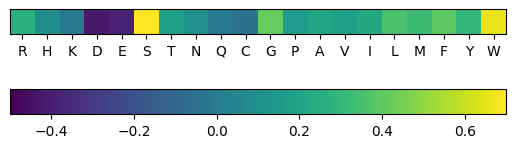

In [51]:
import matplotlib.pyplot as plt
plt.imshow(np.array([avg_contribBF]), cmap='viridis', vmin=-0.5, vmax=0.7)
y_labels = list("RHKDESTNQCGPAVILMFYW")  # Example labels
plt.yticks([])
plt.xticks(ticks=np.arange(len(y_labels)), labels=y_labels)
plt.colorbar(orientation='horizontal')
plt.savefig('LazBF_AA_contrib.png', dpi=400, bbox_inches='tight', pad_inches=0)

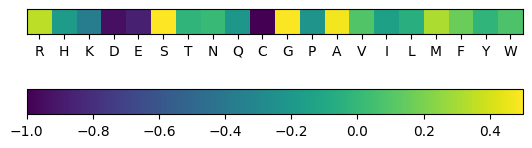

In [52]:
plt.imshow(np.array([avg_contribDEF]), cmap='viridis', vmin=-1, vmax=0.5)
y_labels = list("RHKDESTNQCGPAVILMFYW")  # Example labels
plt.yticks([])
plt.xticks(ticks=np.arange(len(y_labels)), labels=y_labels)
plt.colorbar(orientation='horizontal')
plt.savefig('LazDEF_AA_contrib.png', dpi=400, bbox_inches='tight', pad_inches=0)

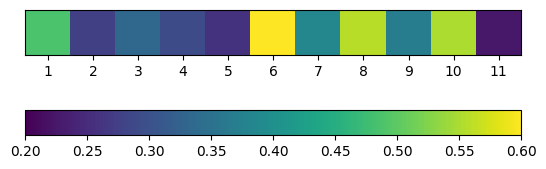

In [53]:
plt.imshow(np.array([avg_position_contribBF]), cmap='viridis', vmin=0.2, vmax=0.6)
y_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]  # Example labels
plt.yticks([])
plt.xticks(ticks=np.arange(len(y_labels)), labels=y_labels)
plt.colorbar(orientation='horizontal')
plt.savefig('LazBF_pos_contrib.png', dpi=400, bbox_inches='tight', pad_inches=0)

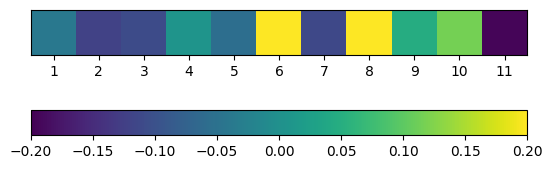

In [54]:
plt.imshow(np.array([avg_position_contribDEF]), cmap='viridis', vmin=-0.2, vmax=0.2)
y_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]  # Example labels
plt.yticks([])
plt.xticks(ticks=np.arange(len(y_labels)), labels=y_labels)
plt.colorbar(orientation='horizontal')
plt.savefig('LazDEF_pos_contrib.png', dpi=400, bbox_inches='tight', pad_inches=0)

In [55]:
# Delete position 5 and serine residue as their contributions to substrate fitness are obvious
avg_contribBF = np.delete(avg_contribBF, 5)
avg_contribDEF = np.delete(avg_contribDEF, 5)
avg_position_contribBF = np.delete(avg_position_contribBF, 5)
avg_position_contribDEF = np.delete(avg_position_contribDEF, 5)

In [56]:
from scipy.stats import spearmanr
print(spearmanr(avg_contribBF, avg_contribDEF))
print(spearmanr(avg_position_contribBF, avg_position_contribDEF))
print(spearmanr(np.nan_to_num(avg_positionBF, nan=0.0).flatten(), np.nan_to_num(avg_positionDEF, nan=0.0).flatten()))

SignificanceResult(statistic=0.7789473684210525, pvalue=8.503539208142179e-05)
SignificanceResult(statistic=0.7333333333333332, pvalue=0.01580059625057158)
SignificanceResult(statistic=0.5867492909461007, pvalue=9.61098530273787e-22)
